Analyse des Tweets en tempts réels

In [19]:
#Bibliothèques

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from time import sleep
import easygui

import pymongo
from pymongo import MongoClient

from textblob import TextBlob

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Seuils pour la classification des sentiments
seuil_negatif = -0.1
seuil_positif = 0.1

# Fonction pour classifier le sentiment en fonction de la polarité
def classifier_sentiment(polarite):
    if polarite < seuil_negatif:
        return "négatif"
    elif polarite > seuil_positif:
        return "positif"
    else:
        return "neutre"

# Fonction pour demander le sujet de recherche à l'utilisateur
def obtenir_sujet_recherche():
    msg = "Entrez le sujet que vous souhaitez rechercher sur Twitter :"
    titre = "Sujet de recherche"
    defaut = "غزة"  # Valeur par défaut
    sujet_recherche = easygui.enterbox(msg, titre, default=defaut)
    return sujet_recherche

# Connexion à MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["BigData"]
collection = db["tweets_A"]

# Connexion à Twitter via Selenium WebDriver
service = webdriver.chrome.service.Service()
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=service, options=options)
driver.get("https://twitter.com/i/flow/login")

# Attendre que la page se charge
sleep(3)  

try:
    # Identification
    username = driver.find_element(By.NAME, 'text')
    username.send_keys("YMekrany")  # Nom d'utilisateur

    sui = driver.find_element(By.XPATH, '//span[contains(text(), "Suivant")]')
    sui.click()

    sleep(3)
    password = driver.find_element(By.NAME, 'password')
    password.send_keys("0608410180")  # Mot de passe

    conn = driver.find_element(By.XPATH, '//span[contains(text(), "Se connecter")]')
    conn.click()

    # Obtenir le sujet de recherche de l'utilisateur
    sujet_recherche = obtenir_sujet_recherche()

    # Effectuer la recherche
    sleep(3)
    search_box = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.XPATH, '//input[@data-testid="SearchBox_Search_Input"]'))
    )
    search_box.send_keys(sujet_recherche)
    search_box.send_keys(Keys.ENTER)

    tweets = []

    # Itérer pour récupérer les tweets
    while len(tweets) < 1000:
        articles = driver.find_elements(By.XPATH, '//*[@data-testid="tweet"]')
        for article in articles:
            try:
                # Extraire les données du tweet
                tweet_text = article.find_element(By.XPATH, './/*[@data-testid="tweetText"]').text

                # Analyser le tweet en utilisant TextBlob
                analyse = TextBlob(tweet_text)
                polarite = analyse.sentiment.polarity  # Obtenir la polarité du sentiment

                # Classifier le sentiment
                sentiment = classifier_sentiment(polarite)

                # Stocker le tweet et le sentiment dans MongoDB
                donnees_tweet = {
                    "tweet": tweet_text,
                    "sentiment": sentiment
                }
                collection.insert_one(donnees_tweet)

                # Ajouter le texte du tweet à la liste
                tweets.append(tweet_text)
            except Exception as e:
                print("Erreur lors de la récupération ou de l'analyse des tweets :", e)

        # Faire défiler vers le bas pour charger plus de tweets
        driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
        sleep(3)  # Attendre que plus de tweets soient chargés

        # Arrêter la boucle si la condition est remplie
        if len(tweets) > 1000:
            break

    print("Nombre de tweets récupérés :", len(tweets))
    print(tweets)
    print()
    print("Les tweets et leurs analyses ont été enregistrés avec succès dans MongoDB")

except Exception as e:
    print("Une erreur s'est produite :", e)

finally:
    # Fermer le navigateur
    driver.quit()


Erreur lors de la récupération ou de l'analyse des tweets : Message: stale element reference: stale element not found in the current frame
  (Session info: chrome=126.0.6478.127); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#stale-element-reference-exception
Stacktrace:
	GetHandleVerifier [0x00007FF73271EEA2+31554]
	(No symbol) [0x00007FF732697ED9]
	(No symbol) [0x00007FF73255872A]
	(No symbol) [0x00007FF73255E55E]
	(No symbol) [0x00007FF732560EB1]
	(No symbol) [0x00007FF732560F50]
	(No symbol) [0x00007FF7325A7F6C]
	(No symbol) [0x00007FF7325A853C]
	(No symbol) [0x00007FF73259BBAC]
	(No symbol) [0x00007FF7325CD06F]
	(No symbol) [0x00007FF73259BA76]
	(No symbol) [0x00007FF7325CD240]
	(No symbol) [0x00007FF7325EC977]
	(No symbol) [0x00007FF7325CCDD3]
	(No symbol) [0x00007FF73259A33B]
	(No symbol) [0x00007FF73259AED1]
	GetHandleVerifier [0x00007FF732A28B1D+3217341]
	GetHandleVerifier [0x00007FF732A75AE3+3532675]
	Ge

In [24]:
#extraire dataset de MongoDB

# Connexion à MongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["BigData"]
collection = db["tweets_A"]

# Récupérer les documents de la collection MongoDB sous forme de liste de dictionnaires
data_list = list(collection.find())

# Créer un DataFrame pandas à partir des données récupérées
data = pd.DataFrame(data_list)

# Afficher les premières lignes du DataFrame pour vérification
data.head()


,_id,tweet,sentiment
0,663a1e512063f2fb8c79a578,الواقع سيئ ومخيف جدا جدا …\nغزة ..,neutre
1,663a1e512063f2fb8c79a579,طبيب كويتي حمل روحه على كفه وخاطر بحياته ونزل ...,neutre
2,663a1e512063f2fb8c79a57a,Don't overpay on Amazon ever again! This Amazo...,neutre
3,663a1e542063f2fb8c79a57b,ما ذنب هذه العائلة، ارتقى الليلة في قصف الاحتل...,neutre
4,663a1e542063f2fb8c79a57c,قبل أشهر كنت هنا ألتقط لأطفالي صورة كلها فرح ل...,neutre


In [26]:
data

,_id,tweet,sentiment
0,663a1e512063f2fb8c79a578,الواقع سيئ ومخيف جدا جدا …\nغزة ..,neutre
1,663a1e512063f2fb8c79a579,طبيب كويتي حمل روحه على كفه وخاطر بحياته ونزل ...,neutre
2,663a1e512063f2fb8c79a57a,Don't overpay on Amazon ever again! This Amazo...,neutre
3,663a1e542063f2fb8c79a57b,ما ذنب هذه العائلة، ارتقى الليلة في قصف الاحتل...,neutre
4,663a1e542063f2fb8c79a57c,قبل أشهر كنت هنا ألتقط لأطفالي صورة كلها فرح ل...,neutre
...,...,...,...
2159,66952651f92bdd02e8c3de1c,الجمعة 11 تمّوز 2014: الاحتلال يتهيّب المعركة ...,neutre
2160,66952651f92bdd02e8c3de1d,#غزة_تحت_القصف ولكنها فوق الجميع \n\nغزة تدافع...,neutre
2161,66952652f92bdd02e8c3de1e,تقصف بيوتهم يقولون في المال ولا في العيال\nيست...,neutre
2162,66952652f92bdd02e8c3de1f,شمار شهداي فلسطيني در نوار غزه به 91 نفر رسيد ...,neutre


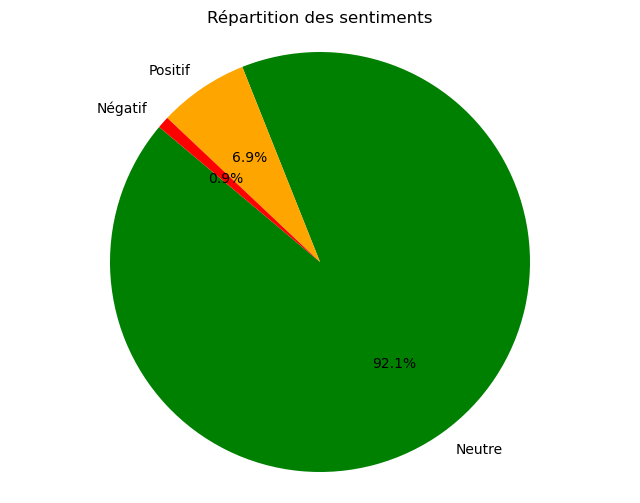

In [28]:
#Affichage en utilisant le diagramme en secteurs

# Supposons que vos textes sont dans une colonne nommée 'texte'
textes = data['tweet']

# Analyse des sentiments pour chaque texte
sentiments = []
for texte in textes:
    blob = TextBlob(str(texte))  # Convertir en chaîne au cas où
    sentiment = blob.sentiment.polarity  # Récupérer la polarité du sentiment
    # Déterminer le sentiment en fonction de la polarité
    if sentiment > 0:
        sentiments.append('Positif')
    elif sentiment == 0:
        sentiments.append('Neutre')
    else:
        sentiments.append('Négatif')

# Ajouter les résultats d'analyse à votre dataset
data['sentiment'] = sentiments

# Compter le nombre de chaque type de sentiment
sentiment_counts = data['sentiment'].value_counts()

# Créer un diagramme en secteurs (pie chart)
plt.figure(figsize=(8, 6))
plt.title('Répartition des sentiments')
colors = ['green', 'orange', 'red']
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.axis('equal')  # Assure que le diagramme en secteurs est un cercle
plt.show()


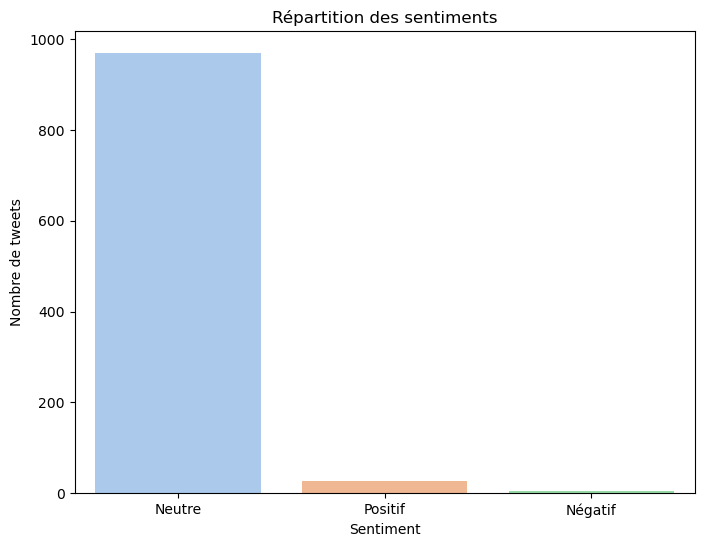

In [5]:
#Affichage en utilisant le diagramme à barres

# Supposons que vos textes sont dans une colonne nommée 'texte'
textes = data['tweet']

# Analyse des sentiments pour chaque texte
sentiments = []
for texte in textes:
    blob = TextBlob(str(texte))  # Convertir en chaîne au cas où
    sentiment = blob.sentiment.polarity  # Récupérer la polarité du sentiment
    # Déterminer le sentiment en fonction de la polarité
    if sentiment > 0:
        sentiments.append('Positif')
    elif sentiment == 0:
        sentiments.append('Neutre')
    else:
        sentiments.append('Négatif')

# Ajouter les résultats d'analyse à votre dataset
data['sentiment'] = sentiments

# Compter le nombre de chaque type de sentiment
sentiment_counts = data['sentiment'].value_counts()

# Créer un diagramme à barres (bar chart)
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=data, palette='pastel')
plt.title('Répartition des sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de tweets')
plt.show()
